Evaluating Regularized Xception model for FER task:

https://github.com/elangarka/Regularized-Xception-FER-Extra-Training-Data-Step-Decay-Learning-Rate

Eval Dataset:

https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition


In [48]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import SeparableConv2D as KerasSeparableConv2D

import os
import cv2
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score


In [49]:
class SeparableConv2DWrapper(KerasSeparableConv2D):
    def __init__(self, *args, **kwargs):
        # Remove unsupported keyword arguments
        kwargs.pop('groups', None)
        kwargs.pop('kernel_initializer', None)
        kwargs.pop('kernel_regularizer', None)
        kwargs.pop('kernel_constraint', None)
        super().__init__(*args, **kwargs)

In [50]:
# Load the model with custom_objects
emotion_model = load_model(
    '../weights/bestXceptionPlusData.h5',
    custom_objects={'SeparableConv2D': SeparableConv2DWrapper}
)

In [51]:
dataset_path = '../datasets/images/'

emotions = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'neutral']

In [52]:
# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

face_cascade = cv2.CascadeClassifier('../src/haarcascade_frontalface_default.xml')

# Loop through each folder (each folder represents an id)
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        # Loop through each image in the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            # Load the image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)

            # If no faces are detected, skip this image
            if len(faces) == 0:
                print(f"No face detected in {img_path}, skipping")
                continue

            # extract the first face
            (x, y, w, h) = faces[0]
            face_roi = img[y:y + h, x:x + w]

            # Resize the face ROI to the required size
            try:
                resized_face = cv2.resize(face_roi, (48, 48), interpolation=cv2.INTER_AREA)
            except cv2.error as e:
                print(f"Error resizing face in {img_path}: {e}, skipping")
                continue

            # Expand dimensions and normalize
            img_array = np.expand_dims(resized_face, axis=0)
            img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
            img_array = img_array.astype('float32') / 255.0

            prediction = emotion_model.predict(img_array)
            predicted_emotion = emotions[np.argmax(prediction)]

            true_labels.append(img_name.split('.')[0].lower())  # Assuming the image name is the true label
            predictions.append(predicted_emotion)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
No face detected in ../datasets/images/10\Surprised.jpg, skipping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

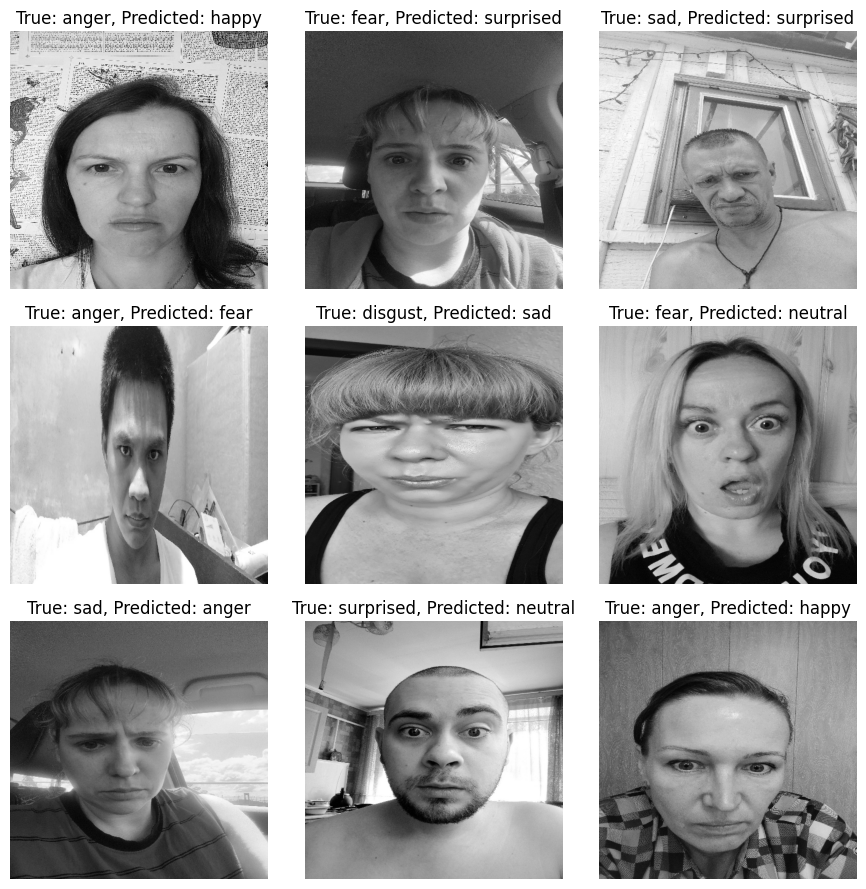

In [53]:
import matplotlib.pyplot as plt

# Find indices where the predictions were incorrect
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]

# Plot up to 10 incorrect predictions
num_images = min(9, len(incorrect_indices))

plt.figure(figsize=(9, 9))
for i in range(num_images):
    index = incorrect_indices[i]
    img_path = os.path.join(dataset_path, str(index % 10), f'{true_labels[index].capitalize()}.jpg') # Construct the image path
    img = image.load_img(img_path, target_size=(480, 480), color_mode='grayscale')
    img_array = image.img_to_array(img)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array.reshape(480, 480), cmap='gray')
    plt.title(f"True: {true_labels[index]}, Predicted: {predictions[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

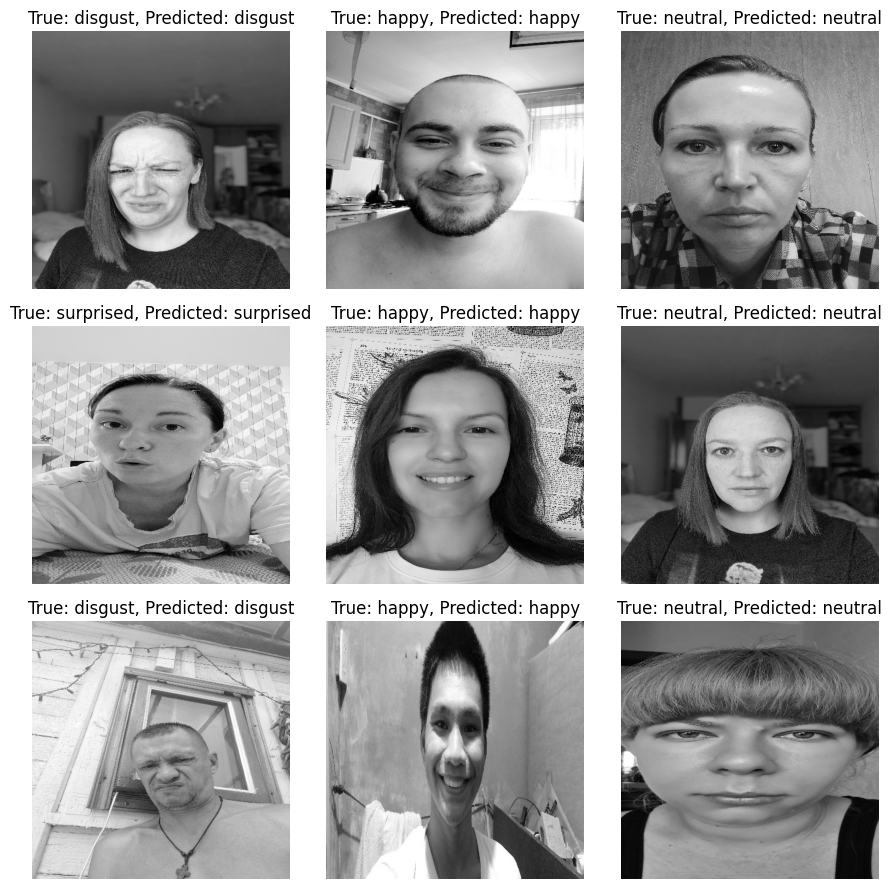

In [54]:
import matplotlib.pyplot as plt

# Find indices where the predictions were incorrect
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] == predictions[i]]

# Plot up to 10 incorrect predictions
num_images = min(9, len(incorrect_indices))

plt.figure(figsize=(9, 9))
for i in range(num_images):
    index = incorrect_indices[i]
    img_path = os.path.join(dataset_path, str(index % 10), f'{true_labels[index].capitalize()}.jpg') # Construct the image path
    img = image.load_img(img_path, target_size=(480, 480), color_mode='grayscale')
    img_array = image.img_to_array(img)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array.reshape(480, 480), cmap='gray')
    plt.title(f"True: {true_labels[index]}, Predicted: {predictions[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()